Connected to base (Python 3.12.4)

In [ ]:
import numpy as np 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

<Axes: >

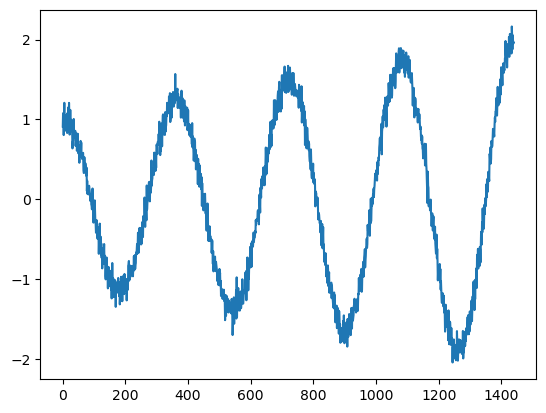

In [ ]:
num_points = 360*4
X = np.arange(num_points)
y = [np.cos(X[i]*np.pi/180) * (1+i/num_points) + (np.random.randn(1)*0.1)[0] for i in range(len(X))]
sns.lineplot(x=X, y=y)

In [ ]:
X_restruct = [] 
y_restruct = [] 

for i in range(num_points-10):
     list1 = []
     for j in range(i,i+10):
         list1.append(y[j])
     X_restruct.append(list1)
     y_restruct.append(y[j+1])
X_restruct = np.array(X_restruct)
y_restruct = np.array(y_restruct)

In [ ]:
train_test_clipping = 360*3
X_train = X_restruct[:train_test_clipping]
X_test = X_restruct[train_test_clipping:]
y_train = y_restruct[:train_test_clipping]
y_test = y_restruct[train_test_clipping:]

In [ ]:
# Dataset 
class TrigonometricDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataloader
train_loader = DataLoader(TrigonometricDataset(X_train, y_train), batch_size=2)
test_loader = DataLoader(TrigonometricDataset(X_test, y_test), batch_size=len(y_test))

<Axes: >

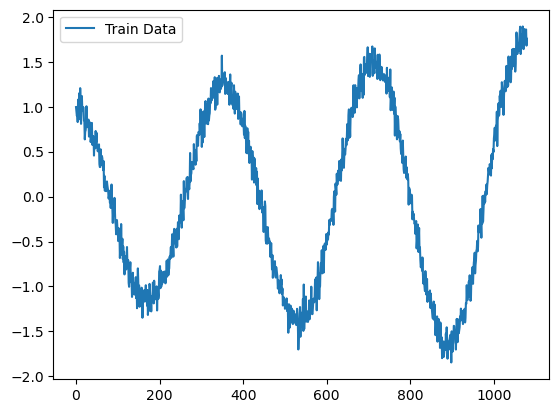

In [ ]:
sns.lineplot(x=range(len(y_train)), y=y_train, label = 'Train Data')

In [ ]:
class TrigonometryModel(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super(TrigonometryModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x, status = self.lstm(x)    
        x = x[:, -1, :]  # reshape for fc layer; out: BS, hidden
        x = self.fc1(x)
        # x = self.relu(x)

        return x

In [ ]:
model = TrigonometryModel()
# input = torch.rand((2, 10, 1))  # BS, seq_len, input_size
# model(input).shape  # out: [BS, seq_len, hidden]

In [ ]:
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
NUM_EPOCHS = 40

In [ ]:
for epoch in range(NUM_EPOCHS):
    for j, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X.view(-1, 10, 1))
        loss = loss_fun(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.data}")

Epoch: 0, Loss: 0.8672767877578735
Epoch: 0, Loss: 0.7652441263198853
Epoch: 0, Loss: 0.8573745489120483
Epoch: 0, Loss: 0.7298310995101929
Epoch: 0, Loss: 0.9922530651092529
Epoch: 0, Loss: 1.1772761344909668
Epoch: 0, Loss: 0.7193787097930908
Epoch: 0, Loss: 1.012988567352295
Epoch: 0, Loss: 0.8799031972885132
Epoch: 0, Loss: 0.7701994180679321
Epoch: 0, Loss: 0.49591296911239624
Epoch: 0, Loss: 0.47874706983566284
Epoch: 0, Loss: 0.7465357780456543
Epoch: 0, Loss: 0.6126397848129272
Epoch: 0, Loss: 0.5884277820587158
Epoch: 0, Loss: 0.5299680233001709
Epoch: 0, Loss: 0.5525327324867249
Epoch: 0, Loss: 0.4670105278491974
Epoch: 0, Loss: 0.3775576949119568
Epoch: 0, Loss: 0.44662243127822876
Epoch: 0, Loss: 0.35191404819488525
Epoch: 0, Loss: 0.27824217081069946
Epoch: 0, Loss: 0.32841289043426514
Epoch: 0, Loss: 0.3607889413833618
Epoch: 0, Loss: 0.38238656520843506
Epoch: 0, Loss: 0.26762253046035767
Epoch: 0, Loss: 0.23032133281230927
Epoch: 0, Loss: 0.28815412521362305
Epoch: 0, L

<Axes: >

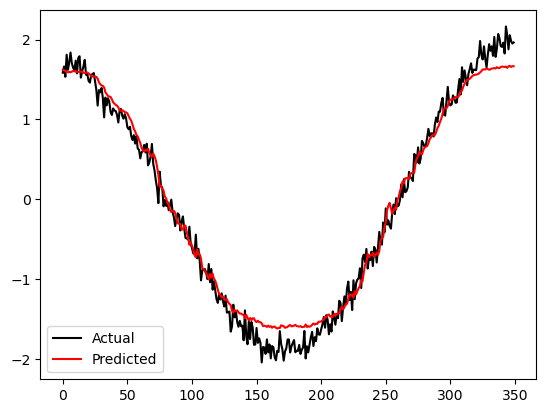

In [ ]:
test_set = TrigonometricDataset(X_test, y_test)
X_test_torch, y_test_torch = next(iter(test_loader))
with torch.no_grad():
    y_pred = model(torch.unsqueeze(X_test_torch, 2)).detach().squeeze().numpy()
y_act = y_test_torch.numpy()
x_act = range(y_act.shape[0])
sns.lineplot(x=x_act, y=y_act, label = 'Actual',color='black')
sns.lineplot(x=x_act, y=y_pred, label = 'Predicted',color='red')

<Axes: >

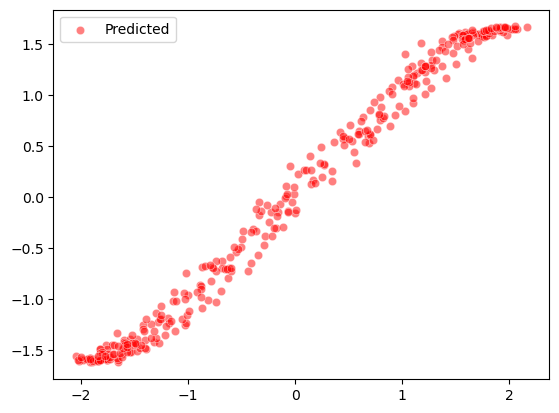

In [ ]:
sns.scatterplot(x=y_act, y=y_pred, label = 'Predicted',color='red', alpha=0.5)

<Axes: >

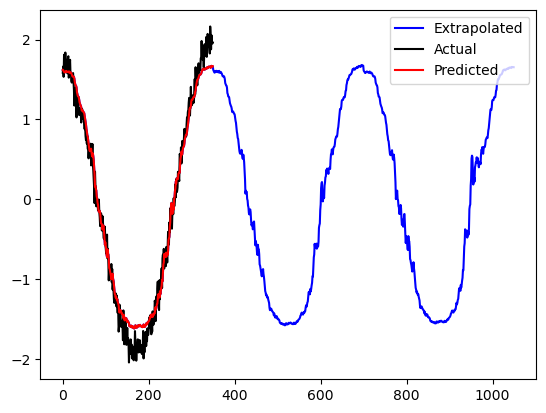

In [ ]:
# solution by Fabian Stohr
num_future_steps = 3
 
# Initialize a new input tensor with additional future steps
X_extrapolate = torch.cat((X_test_torch.unsqueeze(2), torch.zeros(X_test_torch.shape[0], num_future_steps, 1)), dim=1)

with torch.no_grad():
    for i in range(X_test_torch.shape[1], X_test_torch.shape[1] + num_future_steps):
        # Prediction des nächsten Wertes
        next_pred = model(X_extrapolate[:, :i, :])
        
        # Update des Input Tensors mit dem letzten vorhergesagten Wert
        X_extrapolate[:, i, :] = next_pred.view(-1, 1)
 
    # Squeeze und numpy umwandeln, für die Visualisierung
    y_pred_extrapolated = X_extrapolate[:, -num_future_steps:, :].squeeze(2).cpu().numpy()
 
# visualize extrapolation
sns.lineplot(x= np.linspace(0, len(y_pred_extrapolated.flatten('F'))-1, num=len(y_pred_extrapolated.flatten('F'))), y=y_pred_extrapolated.flatten('F'), label='Extrapolated', color='blue')
 
sns.lineplot(x=x_act, y=y_act, label = 'Actual',color='black')
 
sns.lineplot(x=x_act, y=y_pred, label = 'Predicted',color='red')